# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
top_mcc_scores = {
    
    'CHEMBL205': 0.862,
    'CHEMBL301': 0.926,
    'CHEMBL240': 0.884,
    'CHEMBL219': 0.887,
    'CHEMBL244': 0.983,
    'CHEMBL218': 0.941,
    'CHEMBL1978': 0.904}

In [2]:
!nvidia-smi

Wed Apr  6 14:54:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 29%   56C    P0    59W / 240W |    539MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [11]:
dataset='CHEMBL205'

In [12]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
#df = pd.read_csv(path/f'{dataset}.csv')

In [13]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/.ipynb_checkpoints'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/mol_images'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240')]

# Generate activations

In [14]:
DATA = path/'mol_images'

# Create train validation split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    df = pd.read_csv(path/f'{dataset}/{dataset}_cl.csv')
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df

In [17]:
df = get_df(dataset)

# Create dataloader

In [18]:
from fastai.vision.all import *

In [19]:
# No flips, some rotation and zoom. Normalize to imagenet_stats as
# we're using pretrained models.
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [20]:
def get_dls(dataset, df, random_state=42, test_size=0.2, bs=64):
    IMAGES = DATA/dataset
    x_train, x_valid = train_test_split(df.index, test_size=0.2, random_state=random_state, stratify=df['Activity'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['CID'] + '.png'
    images = df['CID'] + ".png"
    db = DataBlock(
        blocks = (ImageBlock(), CategoryBlock()), 
        get_x=ColReader('Image', pref=IMAGES),
        get_y=ColReader('Activity'), 
        splitter=ColSplitter('is_valid'),
        item_tfms=None, 
        batch_tfms=batch_tfms,
        )
    dls = db.dataloaders(df, bs=bs, shuffle_train=True)
    return dls

In [21]:
dls = get_dls(dataset, df, random_state=42)

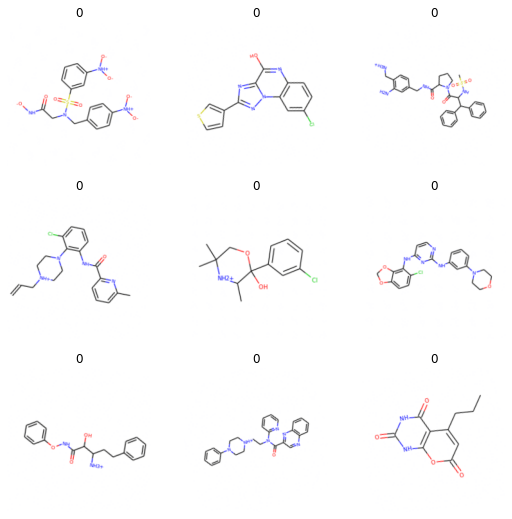

In [22]:
dls.show_batch()

In [23]:
def get_loss_func(df):
    TARGET = 'Activity'
    class_count_df = df.groupby(TARGET).count()
    n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]
    w_0 = (n_0 + n_1) / (2.0 * n_0)
    w_1 = (n_0 + n_1) / (2.0 * n_1)
    class_weights=torch.FloatTensor([w_0, w_1]).cuda()
    loss_func = CrossEntropyLossFlat(weight=class_weights)
    return loss_func

In [24]:
loss_func = get_loss_func(df)

# Train CNN model

In [25]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

In [26]:
def train_model(dls, arch=resnet18, loss_func=loss_func, epochs=10, wd=None, lr=None):
    
    print(f'Training model on dataset: {dataset}')
    print(f'Architechture: {arch}')
    #print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    print(f'Weight decay: wd={wd}')
    learn = cnn_learner(dls, arch=arch, pretrained=True, 
                            wd=wd,
                            loss_func=loss_func,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])
    
    if lr == None: 
        print(f'Finding learning rate...')
        lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        print(f'Training model with learning rate: {lr_min}')
        lr = lr_min
    else: 
        print(f'Training model with learning rate: {lr}')
    learn.fine_tune(epochs, lr)
    
    return learn

In [27]:
# Train model on resnet18
learn = train_model(dls, epochs=30, lr=3e-3, wd=0.002)

Training model on dataset: CHEMBL205
Architechture: <function resnet18 at 0x7f874e9bff80>
Trained epochs: epochs=30
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.564828,0.469020,0.823628,0.472060,0.324170,0.868098,0.924558,0.460342,00:34


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.287858,0.208110,0.930900,0.710956,0.573308,0.935583,0.977180,0.700389,00:42
1,0.215920,0.267127,0.919476,0.682068,0.531732,0.950920,0.980912,0.675671,00:42
2,0.183937,0.124547,0.960992,0.808219,0.730198,0.904908,0.981259,0.792393,00:42
3,0.179265,0.214150,0.947618,0.764411,0.646186,0.935583,0.980733,0.752018,00:42
4,0.170786,0.219201,0.937587,0.737705,0.596591,0.966258,0.982991,0.730944,00:43
5,0.167332,0.208623,0.929228,0.714607,0.563830,0.975460,0.981757,0.710708,00:42
6,0.166256,0.117811,0.968515,0.839716,0.781003,0.907975,0.980721,0.825238,00:41
7,0.162943,0.181243,0.943717,0.753659,0.625506,0.947853,0.979985,0.743323,00:42
8,0.133646,0.198904,0.945667,0.764208,0.630739,0.969325,0.984321,0.756753,00:42
9,0.162832,0.141327,0.953748,0.789340,0.673160,0.953988,0.981623,0.778897,00:42


In [28]:
interp = ClassificationInterpretation.from_learner(learn)

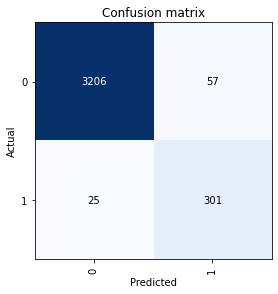

In [29]:
interp.plot_confusion_matrix()

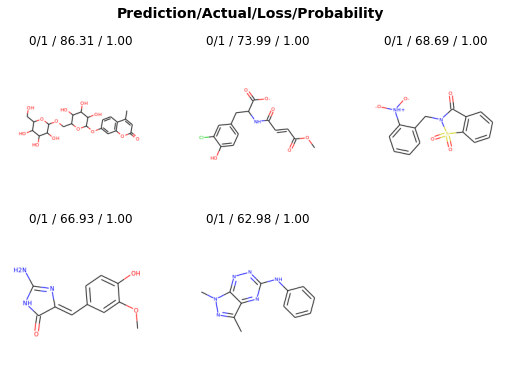

In [30]:
interp.plot_top_losses(k=5)

# Hook the activations from the second last layer

In [39]:
IMAGES=path/f'mol_images/{dataset}'

In [40]:
learn.export(fname= f'models/activation_model.pkl')

In [41]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [42]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=512, bias=False)

In [43]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

In [44]:
df_nodupl=df

In [45]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

In [46]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [47]:
test_dls.items.head()

,CID,SMILES,Image,Activity,is_valid
12127,CHEMBL2333351,Fc1ccc(NC(=O)Nc2cccnc2Oc2cc(ccc2)C(F)(F)F)cc1,CHEMBL2333351.png,0,False
7237,CHEMBL1522618,o1c(ccc1[NH+]([O-])[O-])C(=O)Nc1ccc(cc1)-c1oc2cccnc2n1,CHEMBL1522618.png,0,False
9060,CHEMBL26894,s1ccnc1NS(=O)(=O)c1ccc(O)cc1,CHEMBL26894.png,0,False
13734,CHEMBL270362,O1c2c(c3OC(=O)C=C(c3c3OC(C=Cc23)(C)C)CCC)C(O)C(C)C1C,CHEMBL270362.png,0,False
9310,CHEMBL431448,o1c(nc(CCOc2ccc(cc2)CC([NH+]2CCCCC2)C(=O)[O-])c1C)-c1ccccc1,CHEMBL431448.png,0,True


In [48]:
test_dls.dataset[0]

(PILImage mode=RGB size=224x224, TensorCategory(0))

In [49]:
test_df = test_dls.items.reset_index()

In [50]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     17941 non-null  int64 
 1   CID       17941 non-null  object
 2   SMILES    17941 non-null  object
 3   Image     17941 non-null  object
 4   Activity  17941 non-null  int64 
 5   is_valid  17941 non-null  object
dtypes: int64(2), object(4)
memory usage: 841.1+ KB


In [51]:
df_nodupl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       17941 non-null  object
 1   SMILES    17941 non-null  object
 2   Image     17941 non-null  object
 3   Activity  17941 non-null  int64 
 4   is_valid  17941 non-null  object
dtypes: int64(1), object(4)
memory usage: 700.9+ KB


# Check

In [52]:
test_df.loc[test_df.CID == 'CHEMBL1089637']

,index,CID,SMILES,Image,Activity,is_valid
15300,1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,CHEMBL1089637.png,1,False


In [53]:
df_nodupl.loc[df_nodupl.CID == 'CHEMBL1089637']

,CID,SMILES,Image,Activity,is_valid
1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,CHEMBL1089637.png,1,False


In [54]:
test_dls.dataset

(#17941) [(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0)),(PILImage mode=RGB size=224x224, TensorCategory(0))...]

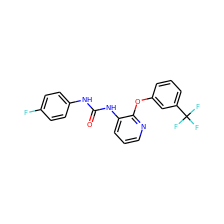

In [55]:
test_dls.dataset[0][0]

In [56]:
test_df.loc[test_df.CID=='CHEMBL1089637']

,index,CID,SMILES,Image,Activity,is_valid
15300,1403,CHEMBL1089637,S(=O)(=O)(N)c1ccc(NC2OCC(O)C(O)C2O)cc1,CHEMBL1089637.png,1,False


In [57]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [58]:
t_img, t_cat = get_data('CHEMBL1089637')

15300


In [59]:
len(test_dls.dataset)

17941

In [60]:
test_dls.dataset[0]

(PILImage mode=RGB size=224x224, TensorCategory(0))

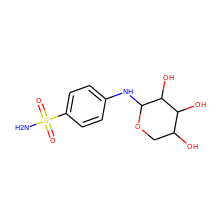

In [61]:
t_img

In [62]:
df_nodupl['activations'] = None

In [63]:
def get_activations(CID, ret=False):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    print(idx)
    data = get_data(CID)
    img = data[0]
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]
    #df_nodupl.iloc[idx]['acts'] = list(acts)
    if not ret: 
        df_nodupl.at[idx, 'activations'] = list(acts)
    if ret: 
        return list(acts)

In [64]:
df_nodupl.CID.values[0]

'CHEMBL188002'

In [65]:
%%capture
for CID in df_nodupl.CID.values:
    get_activations(CID)

In [66]:
df_nodupl.head()

,CID,SMILES,Image,Activity,is_valid,activations
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,CHEMBL188002.png,1,True,"[2.6509247, 4.6314435, -5.79224, -6.340431, 8.945931, -10.024877, -13.597734, -11.811877, 3.7165945, -8.065817, -6.6399107, -8.773628, -3.8007615, 18.800524, 2.3621879, -14.744908, -9.750141, -7.3179, -0.25555727, -1.9475152, 11.363193, -6.1490026, -2.7841487, -6.5230966, -7.517187, 3.6932359, -2.7127004, -11.802076, -10.244245, -7.779312, -14.924008, -8.715547, 4.8857336, -7.027608, -7.7490244, 2.8775716, -5.6927576, -8.1444645, -1.4476175, -3.9109576, -4.988268, -5.0038805, 15.375868, -13.104279, 13.328322, -3.835074, 1.2191267, 2.2834845, 5.7556424, 3.9005156, -11.800068, 10.327564, -12..."
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1,False,"[8.593721, 13.690851, -0.5413939, 0.88854206, -29.09424, -16.853601, -48.06332, -22.635353, -17.30908, -3.6899738, -14.563721, -12.346198, -14.971497, 31.129051, -17.882343, -12.929761, -10.447581, -14.268725, -5.683133, -7.5615926, 28.471611, -21.19216, -26.577682, -8.341239, -40.105232, -7.8852167, 6.7736044, -7.8003025, -19.847729, -30.755411, -19.06014, -8.208006, 25.004156, -6.6506224, -2.0381088, 2.3256981, 12.753311, 2.0405364, 1.7566946, -13.747829, -28.551508, 10.507015, 6.7542686, -16.6969, 14.425744, 11.777209, 10.6663885, 13.860948, 26.264076, 12.072863, -18.385658, -14.152326,..."
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1,False,"[8.376629, 12.396991, 3.2273023, 3.022343, -27.603752, -13.539391, -43.262794, -18.415533, -19.436403, -8.190283, -15.777151, -6.1923494, -19.170647, 27.868916, -22.693344, -12.164142, -9.055517, -20.171532, -11.747545, -8.762781, 20.797606, -18.352694, -27.393927, -10.180745, -36.155125, -10.37778, 4.517227, -8.84462, -15.378998, -31.9423, -14.34182, -9.079492, 23.171352, -6.675901, -0.65929085, 8.724672, 13.796649, 5.500868, 0.68956953, -13.393758, -23.260256, 10.924709, 4.1626797, -16.950003, 13.807396, 7.0951257, 11.223272, 22.940027, 24.521465, 14.010793, -21.454033, -16.736225, -26.8..."
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1,False,"[-11.22326, 13.787741, -14.170083, -26.04346, -19.183771, 2.4107354, -7.326816, -16.650328, -7.8629265, 12.2013235, 5.282713, -24.918333, -10.845752, 13.282839, -9.187281, 2.2906778, 1.3053972, 3.9988966, 15.411796, -16.015146, 15.0345, -24.671408, -10.03668, 18.34907, -14.676984, -7.66921, 7.000497, -11.770479, -4.922135, -9.546266, -12.421812, 6.440583, 19.248491, 4.5410433, -10.993016, -24.841959, 2.5409029, 12.0651655, -16.809107, -8.381027, -8.854639, -0.5329493, 16.36757, 3.2906094, 1.404797, 0.82976013, -0.8023025, -19.683363, 14.333878, -26.509335, 21.587107, -17.498919, -7.8744545..."
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1,False,"[-12.963783, 7.7952847, -13.502033, -19.528086, -17.091442, -11.430966, -12.179832, -21.073002, -8.675916, 3.226983, -1.4252305, -18.951159, -7.010368, 19.702063, 2.9082592, 3.8660376, -0.6687987, 0.3452454, 13.551151, -13.403222, 17.882896, -29.35761, -8.843488, 10.009264, -21.345284, -2.567222, 2.2052774, -12.690865, -5.747219, -7.5104585, -15.072367, -1.8169075, 10.391319, 0.29502404, -6.3636436, -19.55173, -2.026035, 6.3161592, -14.887979, -12.99645, -15.492807, -4.0018435, 7.6013427, -3.810781, 5.1302214, 3.7046545, 1.2226517, -18.094452, 5.4240136, -13.893196, 9.611554, -19.245407, -..."


In [67]:
df_nodupl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CID          17941 non-null  object
 1   SMILES       17941 non-null  object
 2   Image        17941 non-null  object
 3   Activity     17941 non-null  int64 
 4   is_valid     17941 non-null  object
 5   activations  17941 non-null  object
dtypes: int64(1), object(5)
memory usage: 841.1+ KB


In [68]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [69]:
df_acts.drop('activations', axis=1, inplace=True)

In [70]:
df_acts.head()

,CID,SMILES,Image,Activity,is_valid,act_0,act_1,act_2,act_3,act_4,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,CHEMBL188002.png,1,True,2.650925,4.631444,-5.792240,-6.340431,8.945931,...,18.129520,5.309949,-5.210039,-17.116610,-9.055606,4.634091,-3.354085,1.629419,-1.127981,-23.248831
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1,False,8.593721,13.690851,-0.541394,0.888542,-29.094240,...,31.818106,-23.311417,-31.341822,-44.285118,-31.177505,-23.675413,-4.961856,14.502267,-27.597221,-46.815601
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1,False,8.376629,12.396991,3.227302,3.022343,-27.603752,...,24.969618,-22.784950,-27.366474,-41.785320,-27.749981,-27.690706,-1.892092,15.946785,-27.642776,-42.411682
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1,False,-11.223260,13.787741,-14.170083,-26.043461,-19.183771,...,-10.551398,-11.068316,-18.029770,-9.759663,-13.533766,-21.579380,-18.371758,-14.789217,-4.343027,-17.700535
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1,False,-12.963783,7.795285,-13.502033,-19.528086,-17.091442,...,-3.731981,-6.337741,-19.021770,-14.114734,-3.508770,-8.922503,-15.864436,-10.487333,-11.712017,-22.148630


In [71]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 517 entries, CID to act_511
dtypes: float32(512), int64(1), object(4)
memory usage: 35.7+ MB


In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [75]:
all_activations = df_acts[[f'act_{i}' for i in range(0, 512)]]
all_activations.head()

,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,2.650925,4.631444,-5.792240,-6.340431,8.945931,-10.024877,-13.597734,-11.811877,3.716594,-8.065817,...,18.129520,5.309949,-5.210039,-17.116610,-9.055606,4.634091,-3.354085,1.629419,-1.127981,-23.248831
1,8.593721,13.690851,-0.541394,0.888542,-29.094240,-16.853601,-48.063320,-22.635353,-17.309080,-3.689974,...,31.818106,-23.311417,-31.341822,-44.285118,-31.177505,-23.675413,-4.961856,14.502267,-27.597221,-46.815601
2,8.376629,12.396991,3.227302,3.022343,-27.603752,-13.539391,-43.262794,-18.415533,-19.436403,-8.190283,...,24.969618,-22.784950,-27.366474,-41.785320,-27.749981,-27.690706,-1.892092,15.946785,-27.642776,-42.411682
3,-11.223260,13.787741,-14.170083,-26.043461,-19.183771,2.410735,-7.326816,-16.650328,-7.862926,12.201324,...,-10.551398,-11.068316,-18.029770,-9.759663,-13.533766,-21.579380,-18.371758,-14.789217,-4.343027,-17.700535
4,-12.963783,7.795285,-13.502033,-19.528086,-17.091442,-11.430966,-12.179832,-21.073002,-8.675916,3.226983,...,-3.731981,-6.337741,-19.021770,-14.114734,-3.508770,-8.922503,-15.864436,-10.487333,-11.712017,-22.148630


In [80]:
x = StandardScaler().fit_transform(all_activations)
x

array([[ 0.2880784 ,  0.30681333, -0.6010479 , ...,  0.27006617,
         0.00959135, -1.2087443 ],
       [ 0.63986206,  0.7916341 , -0.12324076, ...,  1.9337963 ,
        -2.7530425 , -2.341027  ],
       [ 0.6270113 ,  0.7223922 ,  0.21969633, ...,  2.1204908 ,
        -2.7577972 , -2.1294374 ],
       ...,
       [-0.9760419 , -1.0851189 ,  1.1317536 , ...,  0.09226172,
        -0.58263844,  1.2600565 ],
       [-0.09172216, -0.32218075, -0.22959803, ...,  0.63404906,
         0.44947395, -0.14052036],
       [-0.45702922, -0.53451717,  1.1043276 , ...,  0.42022607,
         0.43962193,  0.92037445]], dtype=float32)

In [78]:
pca = PCA(n_components=128)

In [81]:
principalComponents = pca.fit_transform(x)

In [83]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = [f'pca_{i}' for i in range(0, 128)])
principalDf.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_118,pca_119,pca_120,pca_121,pca_122,pca_123,pca_124,pca_125,pca_126,pca_127
0,-7.626243,-11.846932,2.181621,2.883427,-4.164511,-3.025412,-1.176717,0.194958,0.644585,-0.373791,...,0.098678,0.060415,-0.061614,-0.131339,0.031808,0.049131,0.018394,-0.004024,-0.189193,0.033769
1,-10.642493,-14.473786,29.402847,3.771606,-0.006615,-0.609860,-3.360197,2.174378,0.160712,-0.892385,...,0.006445,0.076490,-0.005898,0.047445,-0.094570,-0.036108,-0.108462,0.026409,-0.061849,-0.083877
2,-9.040936,-13.375031,30.047092,0.540517,-3.778347,-0.255176,-2.284647,-0.155476,1.301045,-0.250722,...,0.075003,0.126252,0.045264,0.073885,-0.044814,0.076600,-0.085974,0.083727,0.023021,0.140590
3,-11.471535,-0.659898,9.031866,12.397515,12.799420,11.101465,11.714012,0.508676,1.164139,0.424229,...,-0.119512,-0.243272,-0.035284,-0.169405,-0.165121,0.077793,0.002286,0.092607,-0.000398,0.042947
4,-11.336825,-4.353191,8.538470,10.784942,7.161096,9.441827,5.002752,0.651558,-4.085216,-0.384648,...,-0.010942,-0.019184,-0.065507,0.023736,-0.205628,0.044264,-0.167439,0.029012,0.017320,-0.095512


In [85]:
finalDf = pd.concat([df_acts[['CID', 'SMILES', 'Image', 'Activity', 'is_valid']], principalDf], axis = 1)
finalDf.head()

,CID,SMILES,Image,Activity,is_valid,pca_0,pca_1,pca_2,pca_3,pca_4,...,pca_118,pca_119,pca_120,pca_121,pca_122,pca_123,pca_124,pca_125,pca_126,pca_127
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,CHEMBL188002.png,1,True,-7.626243,-11.846932,2.181621,2.883427,-4.164511,...,0.098678,0.060415,-0.061614,-0.131339,0.031808,0.049131,0.018394,-0.004024,-0.189193,0.033769
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1,False,-10.642493,-14.473786,29.402847,3.771606,-0.006615,...,0.006445,0.076490,-0.005898,0.047445,-0.094570,-0.036108,-0.108462,0.026409,-0.061849,-0.083877
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1,False,-9.040936,-13.375031,30.047092,0.540517,-3.778347,...,0.075003,0.126252,0.045264,0.073885,-0.044814,0.076600,-0.085974,0.083727,0.023021,0.140590
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1,False,-11.471535,-0.659898,9.031866,12.397515,12.799420,...,-0.119512,-0.243272,-0.035284,-0.169405,-0.165121,0.077793,0.002286,0.092607,-0.000398,0.042947
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1,False,-11.336825,-4.353191,8.538470,10.784942,7.161096,...,-0.010942,-0.019184,-0.065507,0.023736,-0.205628,0.044264,-0.167439,0.029012,0.017320,-0.095512


In [91]:
pca.explained_variance_ratio_.sum()

0.99873835

# Add ECFP to dataframe

In [93]:
df_ecfp = pd.read_csv(path/f'{dataset}/{dataset}_cl_ecfp_1024.csv')

In [94]:
df_ecfp.head()

,CID,SMILES,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024,Activity
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [95]:
df_ecfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 1027 entries, CID to Activity
dtypes: int64(1025), object(2)
memory usage: 140.6+ MB


In [96]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 517 entries, CID to act_511
dtypes: float32(512), int64(1), object(4)
memory usage: 35.7+ MB


In [97]:
df = df_ecfp.merge(df_acts, on='CID')

In [98]:
df.head()

,CID,SMILES_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,0,0,0,0,0,0,0,0,...,18.129520,5.309949,-5.210039,-17.116610,-9.055606,4.634091,-3.354085,1.629419,-1.127981,-23.248831
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,31.818106,-23.311417,-31.341822,-44.285118,-31.177505,-23.675413,-4.961856,14.502267,-27.597221,-46.815601
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,24.969618,-22.784950,-27.366474,-41.785320,-27.749981,-27.690706,-1.892092,15.946785,-27.642776,-42.411682
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,-10.551398,-11.068316,-18.029770,-9.759663,-13.533766,-21.579380,-18.371758,-14.789217,-4.343027,-17.700535
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,0,0,0,0,0,0,0,0,...,-3.731981,-6.337741,-19.021770,-14.114734,-3.508770,-8.922503,-15.864436,-10.487333,-11.712017,-22.148630


In [99]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [100]:
df.head()

,CID,SMILES_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,act_502,act_503,act_504,act_505,act_506,act_507,act_508,act_509,act_510,act_511
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,0,0,0,0,0,0,0,0,...,18.129520,5.309949,-5.210039,-17.116610,-9.055606,4.634091,-3.354085,1.629419,-1.127981,-23.248831
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,31.818106,-23.311417,-31.341822,-44.285118,-31.177505,-23.675413,-4.961856,14.502267,-27.597221,-46.815601
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,24.969618,-22.784950,-27.366474,-41.785320,-27.749981,-27.690706,-1.892092,15.946785,-27.642776,-42.411682
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,-10.551398,-11.068316,-18.029770,-9.759663,-13.533766,-21.579380,-18.371758,-14.789217,-4.343027,-17.700535
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,0,0,0,0,0,0,0,0,...,-3.731981,-6.337741,-19.021770,-14.114734,-3.508770,-8.922503,-15.864436,-10.487333,-11.712017,-22.148630


In [73]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

In [74]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

In [75]:
df.to_csv(path/f'{dataset}/{dataset}-data-with-ecfp-activations.csv', index=None)

# Create PCA dataframe

In [102]:
df = df_ecfp.merge(finalDf, on='CID')

In [103]:
df.head()

,CID,SMILES_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,pca_118,pca_119,pca_120,pca_121,pca_122,pca_123,pca_124,pca_125,pca_126,pca_127
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,0,0,0,0,0,0,0,0,...,0.098678,0.060415,-0.061614,-0.131339,0.031808,0.049131,0.018394,-0.004024,-0.189193,0.033769
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,0,0,0,0,0,0,0,0,...,0.006445,0.076490,-0.005898,0.047445,-0.094570,-0.036108,-0.108462,0.026409,-0.061849,-0.083877
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,0,0,0,0,0,0,0,0,...,0.075003,0.126252,0.045264,0.073885,-0.044814,0.076600,-0.085974,0.083727,0.023021,0.140590
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],0,0,0,0,0,0,0,0,...,-0.119512,-0.243272,-0.035284,-0.169405,-0.165121,0.077793,0.002286,0.092607,-0.000398,0.042947
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,0,0,0,0,0,0,0,0,...,-0.010942,-0.019184,-0.065507,0.023736,-0.205628,0.044264,-0.167439,0.029012,0.017320,-0.095512


In [104]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [105]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

In [106]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

In [107]:
df.to_csv(path/f'{dataset}/{dataset}_cl-data-with-pca-activations.csv', index=None)